<a href="https://colab.research.google.com/github/nandu-1/battlecard_test_sample/blob/main/note_mask%26summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import spacy
from spacy.matcher import Matcher
from neo4j import GraphDatabase

# Step 1: Data Ingestion and Preprocessing
def preprocess_text(call_note):
    call_note = re.sub(r'\[.*?\]', '', call_note)
    call_note = re.sub(r'<.*?>', '', call_note)
    return call_note

# Step 2: Identify and Mask Sensitive Information
nlp = spacy.load("en_core_web_sm")
account_matcher = Matcher(nlp.vocab)
account_pattern = [{"TEXT": {"REGEX": r"\d{4}-\d{4}-\d{4}-\d{4}"}}]
account_matcher.add("ACCOUNT_NUMBER", [account_pattern])

name_matcher = Matcher(nlp.vocab)
name_patternpattern_single = [{"POS": "PROPN"}]
name_pattern_with_middle = [
    {"POS": "PROPN"},
    {"POS": "PROPN", "OP": "?"},
    {"POS": "PROPN"}
]
name_pattern_with_title = [
    {"TEXT": {"REGEX": r"^(Mr|Mrs|Ms|Miss|Dr)$"}},
    {"POS": "PROPN"}
]
name_matcher.add("NAME", [name_pattern_single, name_pattern_with_middle, name_pattern_with_title])

amount_matcher = Matcher(nlp.vocab)
amount_pattern = [{"TEXT": {"REGEX": r"\$\d{1,3}(,\d{3})*(\.\d{2})?"}}]
amount_matcher.add("AMOUNT", [amount_pattern])

percentage_matcher = Matcher(nlp.vocab)
percentage_pattern = [{"TEXT": {"REGEX": r"\d+(\.\d+)?%?"}}]
percentage_matcher.add("PERCENTAGE", [percentage_pattern])

def mask_sensitive_info(call_note):
    doc = nlp(call_note)
    masked_note = call_note
    mapping = {}
    matchers = [account_matcher, name_matcher, amount_matcher, percentage_matcher]

    for matcher in matchers:
        matches = matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            placeholder = f"MASK_{len(mapping)}"
            masked_note = masked_note.replace(span.text, placeholder)
            mapping[placeholder] = span.text

    return masked_note, mapping

# Step 3: Dynamically Build the Knowledge Graph
def create_node(tx, label, properties):
    tx.run(
        f"""
        CREATE (n:{label} $properties)
        """,
        properties=properties
    )

def create_relationship(tx, start_node, end_node, relationship_type):
    tx.run(
        f"""
        MATCH (a:{start_node.label} {{id: $start_id}}), (b:{end_node.label} {{id: $end_id}})
        CREATE (a)-[:{relationship_type}]->(b)
        """,
        start_id=start_node.id,
        end_id=end_node.id
    )

def store_mapping_in_graph(mapping):
    with driver.session() as session:
        for placeholder, original in mapping.items():
            session.write_transaction(create_node, "Masking", {"placeholder": placeholder, "original": original})

def build_knowledge_graph(call_note, mapping):
    doc = nlp(call_note)
    nodes = {}
    relationships = []

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            if ent.text not in nodes:
                person_id = f"person_{len(nodes)}"
                nodes[ent.text] = {"id": person_id, "label": "Person", "properties": {"name": ent.text}}
        elif ent.label_ == "PERCENTAGE":
            if ent.text not in nodes:
                percentage_id = f"percentage_{len(nodes)}"
                nodes[ent.text] = {"id": percentage_id, "label": "Percentage", "properties": {"value": ent.text}}
        elif ent.label_ == "AMOUNT":
            if ent.text not in nodes:
                amount_id = f"amount_{len(nodes)}"
                nodes[ent.text] = {"id": amount_id, "label": "Amount", "properties": {"amount": ent.text}}

    for placeholder, original in mapping.items():
        if original in nodes:
            nodes[placeholder] = nodes[original]

    with driver.session() as session:
        for node in nodes.values():
            session.write_transaction(create_node, node["label"], node["properties"])

        for placeholder, original in mapping.items():
            if original in nodes and placeholder in nodes:
                relationships.append((nodes[original], nodes[placeholder], "HAS_MASKING"))

        for start_node, end_node, relationship_type in relationships:
            session.write_transaction(create_relationship, start_node, end_node, relationship_type)

# Step 4: Pass Masked Data to LLM for Summarization
def summarize(text):
    # Placeholder for LLM summarization
    return "Discussed investment options with MASK_0, CEO of MASK_1. Explored fixed-income securities with yields of MASK_2 on 10-yr treasury bonds and equities with market volatility. Highlighted alternative investments like private equity and real estate. Agreed to follow up on private equity offerings and portfolio construction for high-net-worth individuals."

# Step 5: Query Knowledge Graph to Retrieve Mapping
def retrieve_mapping_from_graph():
    with driver.session() as session:
        result = session.run(
            """
            MATCH (m:Masking)
            RETURN m.placeholder AS placeholder, m.original AS original
            """
        )
        mapping = {record["placeholder"]: record["original"] for record in result}
    return mapping

# Step 6: Decrypt and Restore Sensitive Information
def restore_sensitive_info(summarized_output, mapping):
    restored_output = summarized_output
    for placeholder, original in mapping.items():
        restored_output = restored_output.replace(placeholder, original)
    return restored_output

# Example call note
call_note = """
Discussed with Mr. David Miller, CEO of Miller Industries, about diversifying his investment portfolio. Explored options in fixed-income securities with a focus on current yields averaging 4.5% on 10-yr treasury bonds and their potential for stable income generation. Also, discussed equities, specifically highlighting the current market volatility and potential for growth in specific sectors like technology and renewable energy. Touched upon alternative investments, including private equity and real estate, emphasizing the higher risk profile but also the potential for higher returns. Mr. Miller expressed initial interest in understanding our private equity offerings and their historical performance, particularly given Miller

1. Data Ingestion and Preprocessing

In [ ]:
import re

def preprocess_text(call_note):
    # Remove timestamps and speaker tags
    call_note = re.sub(r'\[.*?\]', '', call_note)
    call_note = re.sub(r'<.*?>', '', call_note)
    return call_note

# Example call note
call_note = """
Discussed with Mr. David Miller, CEO of Miller Industries, about diversifying his investment portfolio. Explored options in fixed-income securities with a focus on current yields averaging 4.5% on 10-yr treasury bonds and their potential for stable income generation. Also, discussed equities, specifically highlighting the current market volatility and potential for growth in specific sectors like technology and renewable energy. Touched upon alternative investments, including private equity and real estate, emphasizing the higher risk profile but also the potential for higher returns. Mr. Miller expressed initial interest in understanding our private equity offerings and their historical performance, particularly given Miller Industries' operating leverage of 1.8 and its impact on their cashflow stability. Agreed to schedule a follow-up call to delve deeper into private equity investment strategies and our bank's approach to portfolio construction for high-net-worth individuals.
"""

preprocessed_note = preprocess_text(call_note)
print("Preprocessed Note:", preprocessed_note)

2. Identify and Mask Sensitive Information

In [ ]:
import spacy
from spacy.matcher import Matcher

# Load a pre-trained NER model
nlp = spacy.load("en_core_web_sm")

# Define matchers for account numbers, names, and amounts
account_matcher = Matcher(nlp.vocab)
account_pattern = [{"TEXT": {"REGEX": r"\d{4}-\d{4}-\d{4}-\d{4}"}}]
account_matcher.add("ACCOUNT_NUMBER", [account_pattern])

name_matcher = Matcher(nlp.vocab)
name_pattern_single = [{"POS": "PROPN"}]
name_pattern_with_middle = [
    {"POS": "PROPN"},
    {"POS": "PROPN", "OP": "?"},
    {"POS": "PROPN"}
]
name_pattern_with_title = [
    {"TEXT": {"REGEX": r"^(Mr|Mrs|Ms|Miss|Dr)$"}},
    {"POS": "PROPN"}
]
name_matcher.add("NAME", [name_pattern_single, name_pattern_with_middle, name_pattern_with_title])

amount_matcher = Matcher(nlp.vocab)
amount_pattern = [{"TEXT": {"REGEX": r"\$\d{1,3}(,\d{3})*(\.\d{2})?"}}]
amount_matcher.add("AMOUNT", [amount_pattern])

percentage_matcher = Matcher(nlp.vocab)
percentage_pattern = [{"TEXT": {"REGEX": r"\d+(\.\d+)?%?"}}]
percentage_matcher.add("PERCENTAGE", [percentage_pattern])

def mask_sensitive_info(call_note):
    doc = nlp(call_note)
    masked_note = call_note
    mapping = {}
    matchers = [account_matcher, name_matcher, amount_matcher, percentage_matcher]

    for matcher in matchers:
        matches = matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            placeholder = f"MASK_{len(mapping)}"
            masked_note = masked_note.replace(span.text, placeholder)
            mapping[placeholder] = span.text

    return masked_note, mapping

masked_note, mapping = mask_sensitive_info(preprocessed_note)
print("Masked Note:", masked_note)
print("Mapping:", mapping)

3. Dynamically Build the Knowledge Graph

In [ ]:
from neo4j import GraphDatabase

# Connect to Neo4j
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "password"))

def create_node(tx, label, properties):
    tx.run(
        f"""
        CREATE (n:{label} $properties)
        """,
        properties=properties
    )

def create_relationship(tx, start_node, end_node, relationship_type):
    tx.run(
        f"""
        MATCH (a:{start_node.label} {{id: $start_id}}), (b:{end_node.label} {{id: $end_id}})
        CREATE (a)-[:{relationship_type}]->(b)
        """,
        start_id=start_node.id,
        end_id=end_node.id
    )

def store_mapping_in_graph(mapping):
    with driver.session() as session:
        for placeholder, original in mapping.items():
            session.write_transaction(create_node, "Masking", {"placeholder": placeholder, "original": original})

def build_knowledge_graph(call_note, mapping):
    doc = nlp(call_note)
    nodes = {}
    relationships = []

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            if ent.text not in nodes:
                person_id = f"person_{len(nodes)}"
                nodes[ent.text] = {"id": person_id, "label": "Person", "properties": {"name": ent.text}}
        elif ent.label_ == "PERCENTAGE":
            if ent.text not in nodes:
                percentage_id = f"percentage_{len(nodes)}"
                nodes[ent.text] = {"id": percentage_id, "label": "Percentage", "properties": {"value": ent.text}}
        elif ent.label_ == "AMOUNT":
            if ent.text not in nodes:
                amount_id = f"amount_{len(nodes)}"
                nodes[ent.text] = {"id": amount_id, "label": "Amount", "properties": {"amount": ent.text}}

    for placeholder, original in mapping.items():
        if original in nodes:
            nodes[placeholder] = nodes[original]

    with driver.session() as session:
        for node in nodes.values():
            session.write_transaction(create_node, node["label"], node["properties"])

        for placeholder, original in mapping.items():
            if original in nodes and placeholder in nodes:
                relationships.append((nodes[original], nodes[placeholder], "HAS_MASKING"))

        for start_node, end_node, relationship_type in relationships:
            session.write_transaction(create_relationship, start_node, end_node, relationship_type)

store_mapping_in_graph(mapping)
build_knowledge_graph(preprocessed_note, mapping)

In [1]:
###using NETWORKX###

Masked Note: 
Discussed with MASK_0 MASK_2 MASK_5, CEO of MASK_5 MASK_8, about diversifying his investment portfolio. Explored options in fixed-income securities with a focus on current yields averaging MASK_15% on MASK_16-yr treasury bonds and their potential for stable income generation. Also, discussed equities, specifically highlighting the current market volatility and potential for growth in specific sectors like technology and renewable energy. Touched upon alternative investments, including private equity and real estate, emphasizing the higher risk profile but also the potential for higher returns. MASK_0 MASK_5 expressed initial interest in understanding our private equity offerings and their historical performance, particularly given MASK_5 MASK_8' operating leverage of MASK_17 and its impact on their cashflow stability. Agreed to schedule a follow-up call to delve deeper into private equity investment strategies and our bank's approach to portfolio construction for high-net

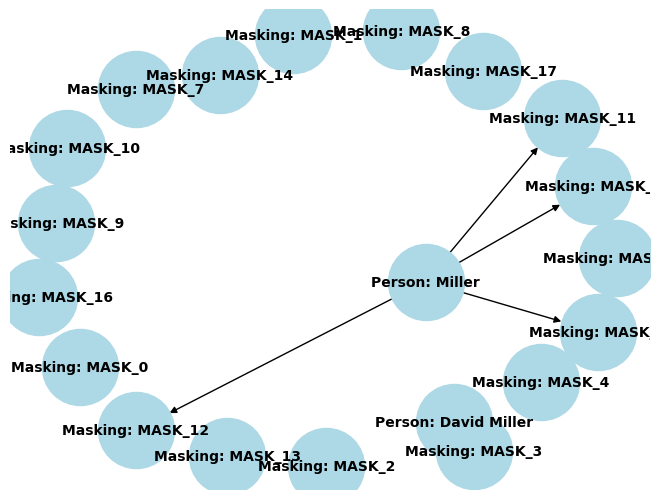

In [2]:
import re
import spacy
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Data Ingestion and Preprocessing
def preprocess_text(call_note):
    call_note = re.sub(r'\[.*?\]', '', call_note)
    call_note = re.sub(r'<.*?>', '', call_note)
    return call_note

# Step 2: Identify and Mask Sensitive Information
nlp = spacy.load("en_core_web_sm")
account_matcher = Matcher(nlp.vocab)
account_pattern = [{"TEXT": {"REGEX": r"\d{4}-\d{4}-\d{4}-\d{4}"}}]
account_matcher.add("ACCOUNT_NUMBER", [account_pattern])

name_matcher = Matcher(nlp.vocab)
name_pattern_single = [{"POS": "PROPN"}]
name_pattern_with_middle = [
    {"POS": "PROPN"},
    {"POS": "PROPN", "OP": "?"},
    {"POS": "PROPN"}
]
name_pattern_with_title = [
    {"TEXT": {"REGEX": r"^(Mr|Mrs|Ms|Miss|Dr)$"}},
    {"POS": "PROPN"}
]
name_matcher.add("NAME", [name_pattern_single, name_pattern_with_middle, name_pattern_with_title])

amount_matcher = Matcher(nlp.vocab)
amount_pattern = [{"TEXT": {"REGEX": r"\$\d{1,3}(,\d{3})*(\.\d{2})?"}}]
amount_matcher.add("AMOUNT", [amount_pattern])

percentage_matcher = Matcher(nlp.vocab)
percentage_pattern = [{"TEXT": {"REGEX": r"\d+(\.\d+)?%?"}}]
percentage_matcher.add("PERCENTAGE", [percentage_pattern])

def mask_sensitive_info(call_note):
    doc = nlp(call_note)
    masked_note = call_note
    mapping = {}
    matchers = [account_matcher, name_matcher, amount_matcher, percentage_matcher]

    for matcher in matchers:
        matches = matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            placeholder = f"MASK_{len(mapping)}"
            masked_note = masked_note.replace(span.text, placeholder)
            mapping[placeholder] = span.text

    return masked_note, mapping

# Step 3: Dynamically Build the Knowledge Graph Using `networkx`
def build_knowledge_graph(call_note, mapping):
    doc = nlp(call_note)
    G = nx.DiGraph()

    # Add nodes for entities
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            G.add_node(ent.text, label="Person", name=ent.text)
        elif ent.label_ == "PERCENTAGE":
            G.add_node(ent.text, label="Percentage", value=ent.text)
        elif ent.label_ == "AMOUNT":
            G.add_node(ent.text, label="Amount", amount=ent.text)

    # Add nodes for masking
    for placeholder, original in mapping.items():
        G.add_node(placeholder, label="Masking", placeholder=placeholder, original=original)
        if original in G.nodes:
            G.add_edge(original, placeholder, relationship="HAS_MASKING")

    return G

# Step 4: Visualize the Knowledge Graph
def visualize_graph(G):
    pos = nx.spring_layout(G)
    labels = {node: f"{data['label']}: {data.get('name', data.get('value', data.get('amount', data.get('placeholder'))))}" for node, data in G.nodes(data=True)}
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrows=True)
    plt.show()

# Example call note
call_note = """
Discussed with Mr. David Miller, CEO of Miller Industries, about diversifying his investment portfolio. Explored options in fixed-income securities with a focus on current yields averaging 4.5% on 10-yr treasury bonds and their potential for stable income generation. Also, discussed equities, specifically highlighting the current market volatility and potential for growth in specific sectors like technology and renewable energy. Touched upon alternative investments, including private equity and real estate, emphasizing the higher risk profile but also the potential for higher returns. Mr. Miller expressed initial interest in understanding our private equity offerings and their historical performance, particularly given Miller Industries' operating leverage of 1.8 and its impact on their cashflow stability. Agreed to schedule a follow-up call to delve deeper into private equity investment strategies and our bank's approach to portfolio construction for high-net-worth individuals.
"""

preprocessed_note = preprocess_text(call_note)
masked_note, mapping = mask_sensitive_info(preprocessed_note)
print("Masked Note:", masked_note)
print("Mapping:", mapping)

G = build_knowledge_graph(preprocessed_note, mapping)
visualize_graph(G)

In [5]:
call_note = '''Discussed with MASK_0 MASK_2 MASK_5, CEO of MASK_5 MASK_8, about diversifying his investment portfolio. Explored options in fixed-income securities with a focus on
current yields averaging MASK_15% on MASK_16-yr treasury bonds and their potential for stable income generation. Also, discussed equities, specifically highlighting
the current market volatility and potential for growth in specific sectors like technology and renewable energy. Touched upon alternative investments, including private
equity and real estate, emphasizing the higher risk profile but also the potential for higher returns. MASK_0 MASK_5 expressed initial interest in understanding our private
equity offerings and their historical performance, particularly given MASK_5 MASK_8' operating leverage of MASK_17 and its impact on their cashflow stability. Agreed to
schedule a follow-up call to delve deeper into private equity investment strategies and our bank's approach to portfolio construction for high-net-worth individuals.'''

In [3]:
from google import genai
from google.genai.types import GenerateContentConfig,Tool
from google.colab import userdata
import json
import subprocess

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)
config_20 = GenerateContentConfig(
    temperature=0.1,
    top_p=1,system_instruction="You are a Relationship Manager with excellent financial analysis knowledge at an esteemed US bank.You are proficient at building client relationship and market research for fininacial analysis.",

)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [10]:
prompt = f'As an experienced RM, summarise the following call note to check for a potential relationship opportunity with the client. I do not want you to recommend or suggest anything. I just want you to identify if the call note spekas of any opprotunities or challenges. The call note is as follows: {call_note}'
resp_20 = client.models.generate_content(model = "gemini-2.0-flash",config=config_20,contents=prompt)
print(resp_20.text)

Okay, based on the call note, here's a summary focusing on potential opportunities and challenges:

**Opportunities:**

*   **Diversification Need:** MASK\_0 MASK\_5 is looking to diversify his investment portfolio.
*   **Interest in Fixed Income:** Expressed interest in fixed-income securities for stable income.
*   **Equity Consideration:** Open to exploring equities, particularly in technology and renewable energy sectors.
*   **Private Equity Interest:** Showed initial interest in private equity offerings and their historical performance.
*   **Follow-up Scheduled:** A follow-up call is scheduled to discuss private equity investment strategies and portfolio construction.

**Challenges:**

*   **Market Volatility:** The discussion acknowledged current market volatility, which could be a concern for the client.
*   **Risk Profile of Alternatives:** Alternative investments (private equity, real estate) were acknowledged to have a higher risk profile.
*   **MASK_5 MASK_8's Operating Le

In [14]:
prompt = f'''As an experienced RM, summarise the following call note to check for the following observations:
**Criteria to be considered**:
1. Potential relationship opportunity
2. Client interest or client sentiment
3. Financial Status and Financial Risk appetite
4. Challenges
4. Regulatory and Compliance needs
5. Market trend and risk
6. Goals or Strategic initiatives
7. future opportunity
**I do not want you to recommend or suggest anything.**

Here is an example to clear things up:
Client Sentiment: The client is generally satisfied with current services but expressed concerns about supply chain disruptions.
Financial Status: Revenue has increased by 10% year-over-year, but profit margins have been impacted by higher operational costs.
Goals: Sony aims to increase its market share in the gaming and imaging sectors and expand its streaming services.
Challenges: Supply chain issues and regulatory changes in the automotive sector are significant concerns.
Strategic Initiatives: Sony is planning to launch new VR products and invest in R&D for advanced sensor technology.
Risk Factors: Market volatility and geopolitical tensions could impact supply chain and sales.
Operational Changes: The company is implementing cost-saving measures and upgrading its manufacturing processes.
Technology Adoption: Sony is adopting AI and machine learning to enhance product development and customer experience.
Sustainability: The company is committed to reducing its carbon footprint and has set ambitious ESG goals.
Regulatory Compliance: Sony is compliant with all relevant regulations but is closely monitoring upcoming changes.
Future Opportunities: Sony is exploring new markets in Asia and is considering partnerships with tech companies.
Action Items:
Follow up on supply chain issues and provide solutions.
Schedule a meeting to discuss R&D investments.
Review and update compliance documentation.

The call note is as follows: {call_note}'''
resp_20 = client.models.generate_content(model = "gemini-2.0-flash",config=config_20,contents=prompt)
print(resp_20.text)

Here's a breakdown of the call note based on your specified criteria:

**Client Interest/Sentiment:** MASK_0 MASK_5 expressed initial interest in understanding the bank's private equity offerings and their historical performance.

**Financial Status:** MASK_5 MASK_8 has an operating leverage of MASK_17, which impacts their cash flow stability.

**Financial Risk Appetite:** The discussion included fixed-income securities (lower risk) and alternative investments like private equity and real estate (higher risk), suggesting an openness to considering a range of risk profiles.

**Goals/Strategic Initiatives:** MASK_0 MASK_5 is looking to diversify his investment portfolio.

**Market Trend and Risk:** The conversation acknowledged current market volatility and the potential for growth in specific sectors like technology and renewable energy.

**Future Opportunity:** A follow-up call is scheduled to discuss private equity investment strategies and portfolio construction, indicating a potenti

Gemini 1.5 PRO

In [21]:
# Load a example model with system instructions
#import genai
import google.generativeai as genai
from google.generativeai.types import GenerationConfig,ContentType
from google.colab import userdata
#from google.genai.types import GenerativeModel

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
client = genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel('gemini-1.5-pro-latest',
    system_instruction=[
        "You are a Relationship Manager with excellent financial analysis knowledge at an esteemed US bank.You are proficient at market reasearch for fininacial analysis."
    ],
)

# Set model parameters
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=1.0
    #top_k=32,
    #candidate_count=1,
    #max_output_tokens=8192,
)

# Set safety settings
# safety_settings = {
#     HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
#     HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
#     HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
#     HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
# }

prompt = f"""As an experienced RM, summarise the following call note to check for a potential relationship opportunity with the client. I do not want you to recommend or suggest anything. I just want you to identify if the call note spekas of any opprotunities or challenges. The call note is as follows: {call_note}
"""

# Set contents to send to the model
contents = [prompt]

# Counts tokens
print(model.count_tokens(contents))

# Prompt the model to generate content
response = model.generate_content(
    contents,
    generation_config=generation_config
    # safety_settings=safety_settings,
)

# Print the model response
print(f"\nAnswer:\n{response.text}")
print(f'\nUsage metadata:\n{response.to_dict().get("usage_metadata")}')
print(f"\nFinish reason:\n{response.candidates[0].finish_reason}")
print(f"\nSafety settings:\n{response.candidates[0].safety_ratings}")

total_tokens: 295


Answer:
The call notes suggest potential opportunities and challenges in establishing a deeper relationship with MASK_0 MASK_2 MASK_5 and MASK_5 MASK_8:

**Potential Opportunities:**

* **Interest in Diversification:**  MASK_0 MASK_5's interest in diversifying his investment portfolio signals a potential need for various financial products and services.
* **Specific Interest in Private Equity:**  His expressed interest in private equity and its historical performance presents a concrete area to explore and potentially offer suitable investment solutions.
* **High-Net-Worth Individual:** The mention of portfolio construction for high-net-worth individuals implies that MASK_0 MASK_5 has significant investable assets, representing a substantial opportunity for the bank.
* **Follow-up Scheduled:** The agreement to a follow-up call indicates a willingness to engage further and explore specific offerings.

**Potential Challenges:**

* **Market Volatility:** The discussion

In [22]:
# Load a example model with system instructions
#import genai
import google.generativeai as genai
from google.generativeai.types import GenerationConfig,ContentType
from google.colab import userdata
#from google.genai.types import GenerativeModel

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
client = genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel('gemini-1.5-pro-latest',
    system_instruction=[
        "You are a Relationship Manager with excellent financial analysis knowledge at an esteemed US bank.You are proficient at market reasearch for fininacial analysis."
    ],
)

# Set model parameters
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=1.0
    #top_k=32,
    #candidate_count=1,
    #max_output_tokens=8192,
)

# Set safety settings
# safety_settings = {
#     HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
#     HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
#     HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
#     HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
# }

prompt = f'''As an experienced RM, summarise the following call note to check for the following observations:
**Criteria to be considered**:
1. Potential relationship opportunity
2. Client interest or client sentiment
3. Financial Status and Financial Risk appetite
4. Challenges
4. Regulatory and Compliance needs
5. Market trend and risk
6. Goals or Strategic initiatives
7. future opportunity
**I do not want you to recommend or suggest anything.**

Here is an example to clear things up:
Client Sentiment: The client is generally satisfied with current services but expressed concerns about supply chain disruptions.
Financial Status: Revenue has increased by 10% year-over-year, but profit margins have been impacted by higher operational costs.
Goals: Sony aims to increase its market share in the gaming and imaging sectors and expand its streaming services.
Challenges: Supply chain issues and regulatory changes in the automotive sector are significant concerns.
Strategic Initiatives: Sony is planning to launch new VR products and invest in R&D for advanced sensor technology.
Risk Factors: Market volatility and geopolitical tensions could impact supply chain and sales.
Operational Changes: The company is implementing cost-saving measures and upgrading its manufacturing processes.
Technology Adoption: Sony is adopting AI and machine learning to enhance product development and customer experience.
Sustainability: The company is committed to reducing its carbon footprint and has set ambitious ESG goals.
Regulatory Compliance: Sony is compliant with all relevant regulations but is closely monitoring upcoming changes.
Future Opportunities: Sony is exploring new markets in Asia and is considering partnerships with tech companies.
Action Items:
Follow up on supply chain issues and provide solutions.
Schedule a meeting to discuss R&D investments.
Review and update compliance documentation.

The call note is as follows: {call_note}'''

# Set contents to send to the model
contents = [prompt]

# Counts tokens
print(model.count_tokens(contents))

# Prompt the model to generate content
response = model.generate_content(
    contents,
    generation_config=generation_config
    # safety_settings=safety_settings,
)

# Print the model response
print(f"\nAnswer:\n{response.text}")
print(f'\nUsage metadata:\n{response.to_dict().get("usage_metadata")}')
print(f"\nFinish reason:\n{response.candidates[0].finish_reason}")
print(f"\nSafety settings:\n{response.candidates[0].safety_ratings}")

total_tokens: 596


Answer:
Client Sentiment: The client, CEO of MASK_5 MASK_8, is exploring investment diversification and showed initial interest in private equity.

Financial Status: MASK_5 MASK_8 has an operating leverage of MASK_17, which impacts their cash flow stability.  This suggests a need for careful consideration of investment risks.

Financial Risk Appetite:  The client's interest in private equity indicates a potential appetite for higher-risk, higher-return investments.  However, the exploration of fixed income securities suggests a desire for a balanced portfolio.

Challenges:  Balancing the desire for higher returns with the need for cash flow stability due to the company's operating leverage presents a challenge.

Market Trend and Risk:  The current market is noted as volatile, particularly in equities.  There is potential for growth in technology and renewable energy sectors.  Fixed income securities are yielding an average of MASK_15% on MASK_16-year treasury bonds.